In [ ]:
# ! uv pip install langfuse
# pip install "opentelemetry-sdk==1.24.0" "opentelemetry-api==1.24.0" "opentelemetry-exporter-otlp-proto-http==1.24.0" --force-reinstall


In [1]:
import os

In [2]:
from langfuse.langchain import CallbackHandler
from dotenv import load_dotenv

load_dotenv()
langfuse_handler = CallbackHandler()

In [3]:
import os
from dotenv import load_dotenv
import pandas as pd
import sqlite3
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_milvus import Milvus # added 

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from typing import Annotated, List, Literal
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import glob
from langfuse.langchain import CallbackHandler
from langsmith import traceable

load_dotenv()
langfuse_handler = CallbackHandler()


os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY", "")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "")


In [4]:

print(f"LangSmith Tracing Enabled: {os.getenv('LANGCHAIN_TRACING_V2')}")
print(f"LangSmith tracing enabled for project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith Tracing Enabled: None
LangSmith tracing enabled for project: rag-agent-with-tools


In [5]:
data_folder = r"./data/imdb"
csv_files = glob.glob(os.path.join(data_folder, '**/*.csv'), recursive=True)
excel_files = glob.glob(os.path.join(data_folder, '**/*.xlsx'), recursive=True)
excel_files += glob.glob(os.path.join(data_folder, '**/*.xls'), recursive=True)
all_files = csv_files + excel_files
print(f"Files found: {len(all_files)}")

# Check if files exist
if len(all_files) == 0:
    raise FileNotFoundError(f"No CSV or Excel files found in '{data_folder}'. Please check the path and add data files.")

Files found: 1


In [6]:
def get_file_info(dataframe, file_path):
    return {
        'columns': dataframe.columns.tolist(),
        'total_rows': len(dataframe),
        'file_path': file_path
    }

def load_file(file_path):
    try:
        if file_path.endswith('.csv'):
            return pd.read_csv(file_path)
        elif file_path.endswith(('.xlsx', '.xls')):
            return pd.read_excel(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    return None

def create_documents_from_file(file_path):
    dataframe = load_file(file_path)
    if dataframe is None or dataframe.empty:
        return [], None
    
    file_info = get_file_info(dataframe, file_path)
    documents = []
    
    for row_number, row_data in dataframe.iterrows():
        content_lines = []
        for column_name in dataframe.columns:
            cell_value = row_data[column_name]
            if pd.notna(cell_value):
                content_lines.append(f"{column_name}: {cell_value}")
        
        if content_lines:
            doc = Document(
                page_content="\n".join(content_lines),
                metadata={
                    'source': file_path,
                    'row_number': row_number,
                    'filename': os.path.basename(file_path)
                }
            )
            documents.append(doc)
    
    return documents, file_info

In [7]:
all_documents = []
all_file_info = []

for file_path in all_files:
    docs, info = create_documents_from_file(file_path)
    if docs:
        all_documents.extend(docs)
        all_file_info.append(info)

print(f"Documents created: {len(all_documents)}")

# Check if documents were created
if len(all_documents) == 0:
    raise ValueError("No documents were created. Please check if your data files contain valid data.")

Documents created: 1000


In [8]:
schema_description = "Available Data:\n\n"
for info in all_file_info:
    filename = os.path.basename(info['file_path'])
    schema_description += f"File: {filename}\n"
    schema_description += f"Columns: {', '.join(info['columns'])}\n"
    schema_description += f"Rows: {info['total_rows']}\n\n"

In [9]:
from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Use from_documents() instead of from_texts()
vectorstore = Milvus.from_documents(
    documents=all_documents,  # Pass Document objects directly
    embedding=embeddings,
    connection_args={"uri": "http://localhost:19530"},
    collection_name="rag_collection"
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
print("Vector store ready")

Vector store ready


In [10]:
sqlite_connection = sqlite3.connect(':memory:')

table_info = {}
for file_path in all_files:
    dataframe = load_file(file_path)
    if dataframe is not None:
        table_name = os.path.splitext(os.path.basename(file_path))[0].replace(' ', '_').replace('-', '_')
        dataframe.to_sql(table_name, sqlite_connection, if_exists='replace', index=False)
        table_info[table_name] = dataframe.columns.tolist()

sql_schema = "Tables:\n\n"
for table_name, columns in table_info.items():
    sql_schema += f"Table: {table_name}\n"
    sql_schema += f"Columns: {', '.join(columns)}\n\n"

print(f"Database ready: {len(table_info)} tables")

Database ready: 1 tables


In [11]:
def retrieve_from_vectors(query: str) -> str:
    retrieved_docs = retriever.invoke(query)
    return "\n\n---\n\n".join([doc.page_content for doc in retrieved_docs])

def run_sql_query(question: str, retry_count: int = 0) -> str:
    if retry_count > 2:
        return "Unable to generate valid SQL query after multiple attempts"
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    prompt = f"""Generate ONLY a valid SQLite query. No explanations, no markdown, no extra text.

{sql_schema}

Question: {question}

Return ONLY the SQL query without any formatting or code blocks."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    sql_query = response.content.strip()
    
    sql_query = sql_query.replace("```sql", "").replace("```", "").strip()
    
    lines = sql_query.split('\n')
    clean_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith('--') and not line.startswith('#'):
            clean_lines.append(line)
    sql_query = ' '.join(clean_lines)
    
    sql_query = sql_query.split(';')[0].strip()
    
    cursor = sqlite_connection.cursor()
    
    try:
        cursor.execute(sql_query)
        results = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        
        result_text = f"SQL: {sql_query}\n\nResults ({len(results)} rows):\n"
        result_text += f"Columns: {', '.join(columns)}\n\n"
        
        for row in results[:20]:
            result_text += str(row) + "\n"
        
        return result_text
    except:
        return run_sql_query(question, retry_count + 1)

In [12]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]
    needs_sql: bool
    context: str
    answer: str
    reflection: str
    retry_count: int
    sql_retry: int

In [13]:
def decide_route(state: AgentState):
    print("[ROUTE]")
    
    user_message = state["messages"][0].content.lower()
    
    sql_keywords = ['count', 'total', 'sum', 'average', 'avg', 'max', 'min', 
                    'top', 'highest', 'lowest', 'how many', 'all', 'most', 'least']
    
    needs_sql = any(keyword in user_message for keyword in sql_keywords)
    
    return {
        "needs_sql": needs_sql,
        "retry_count": 0,
        "sql_retry": 0
    }

def retrieve_vectors(state: AgentState):
    print("[RETRIEVE]")
    
    query = state["messages"][0].content
    context = retrieve_from_vectors(query)
    
    return {"context": context}

def execute_sql(state: AgentState):
    print("[SQL]")
    
    query = state["messages"][0].content
    sql_retry = state.get("sql_retry", 0)
    context = run_sql_query(query, sql_retry)
    
    return {"context": context}

In [14]:
def generate_answer(state: AgentState):
    print("[GENERATE]")
    
    context = state.get("context", "")
    question = state["messages"][0].content
    
    system_msg = f"""Answer using the context provided.

Database Info:
{schema_description}

Be concise and accurate."""
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    response = llm.invoke(
        [
            SystemMessage(content=system_msg),
            HumanMessage(content=f"Context: {context}\n\nQuestion: {question}")
        ],
        config={"callbacks": [langfuse_handler]}
    )
    
    return {"answer": response.content}

def reflect_answer(state: AgentState):
    print("[REFLECT]")
    
    question = state["messages"][0].content
    answer = state["answer"]
    
    prompt = f"""Check if answer addresses question properly.

Question: {question}

Answer: {answer}

Respond 'GOOD' or 'RETRY'."""
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    result = llm.invoke(
        [HumanMessage(content=prompt)],
        config={"callbacks": [langfuse_handler]}
    )
    
    retry_count = state.get("retry_count", 0)
    
    return {
        "reflection": result.content,
        "retry_count": retry_count + 1
    }

def finalize(state: AgentState):
    print("[DONE]")
    
    final_msg = AIMessage(content=state["answer"])
    return {"messages": [final_msg]}

In [15]:
def route_after_decision(state: AgentState) -> Literal["execute_sql", "retrieve_vectors"]:
    if state.get("needs_sql", False):
        return "execute_sql"
    else:
        return "retrieve_vectors"

def route_after_reflection(state: AgentState) -> Literal["retrieve_vectors", "finalize"]:
    retry_count = state.get("retry_count", 0)
    reflection = state.get("reflection", "")
    
    if "good" in reflection.lower():
        return "finalize"
    elif retry_count < 2:
        return "retrieve_vectors"
    else:
        return "finalize"

In [16]:
workflow = StateGraph(AgentState)

workflow.add_node("decide_route", decide_route)
workflow.add_node("retrieve_vectors", retrieve_vectors)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("reflect_answer", reflect_answer)
workflow.add_node("finalize", finalize)

workflow.add_edge(START, "decide_route")

workflow.add_conditional_edges(
    "decide_route",
    route_after_decision,
    {
        "retrieve_vectors": "retrieve_vectors",
        "execute_sql": "execute_sql"
    }
)

workflow.add_edge("retrieve_vectors", "generate_answer")
workflow.add_edge("execute_sql", "generate_answer")
workflow.add_edge("generate_answer", "reflect_answer")

workflow.add_conditional_edges(
    "reflect_answer",
    route_after_reflection,
    {
        "retrieve_vectors": "retrieve_vectors",
        "finalize": "finalize"
    }
)

workflow.add_edge("finalize", END)

graph = workflow.compile()

print("Graph ready")

Graph ready


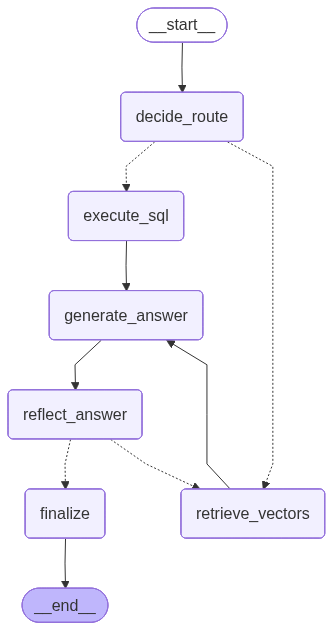

In [18]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:

questions = [
    "Which movie deals with a young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death?",
    "Which movie explores a father’s fight against a supernatural illness threatening his child in a rural village?",
    "Which uplifting Bollywood movie follows a curious outsider asking innocent questions?",
    "Which movie shows how teamwork inside a military command leads to ethical decisions protecting innocent life?",
    "Which movie explores how a blind man regains sight but loses clarity in life due to superficial obsession?",
    "Which movie has the highest IMDb rating in the dataset?",
    "Find the top 3 highest-revenue movies released after 2010, sorted descending.",
    "How many movies have Runtime > 150 minutes AND rating ≥ 8.0?",
    "Which 3 directors have directed the most movies in the dataset?",
    "Count all movies belonging to the Sci-Fi genre (even if mixed)."
]
import time

for question in questions:
    print(f"\nQuestion: {question}")
    
    result = graph.invoke(
        {"messages": [HumanMessage(content=question)]}, #type: ignore
        config={"callbacks": [langfuse_handler]}
    )
    
    print(f"\nAnswer:\n{result['messages'][-1].content}")

    time.sleep(10)


Question: Which movie deals with a young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death?
[ROUTE]
[RETRIEVE]
[GENERATE]
[REFLECT]
[DONE]

Answer:
The movie that deals with a young girl experiencing an out-of-body dilemma after a tragic accident is "If I Stay."

Question: Which movie explores a father’s fight against a supernatural illness threatening his child in a rural village?
[ROUTE]
[RETRIEVE]
[GENERATE]
[REFLECT]
[DONE]

Answer:
The movie that explores a father's fight against a supernatural illness threatening his child in a rural village is "Goksung."

Question: Which uplifting Bollywood movie follows a curious outsider asking innocent questions?
[ROUTE]
[RETRIEVE]
[GENERATE]
[REFLECT]
[DONE]

Answer:
The uplifting Bollywood movie that follows a curious outsider asking innocent questions is "PK," directed by Rajkumar Hirani.

Question: Which movie shows how teamwork inside a military command leads to ethical decision